# 网络爬虫

In [1]:
import time
import requests
import jieba
import wordcloud
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as py
import pandas as pd
from IPython.display import Image
import re

## 第一题 下载图片

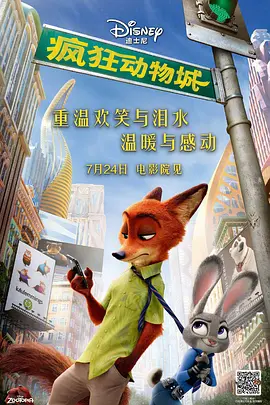

In [2]:
myPoster=requests.get('https://img1.doubanio.com/view/photo/s_ratio_poster/public/p2614500649.webp')
path='poster.png'

with open(path,'wb') as file:
    file.write(myPoster.content)
    
Image(path)

## 第二题 爬取短评及影评数量 

In [3]:
myHeaders={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.64 Safari/537.36 Edg/101.0.1210.53'}

In [4]:
mySum=requests.get('https://movie.douban.com/subject/25662329/',headers=myHeaders)
mySum.encoding='utf-8'
soup=BeautifulSoup(mySum.text,'html.parser')
print(soup)

<!DOCTYPE html>

<html class="ua-windows ua-webkit" lang="zh-CN">
<head>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="webkit" name="renderer"/>
<meta content="always" name="referrer"/>
<meta content="ok0wCgT20tBBgo9_zat2iAcimtN4Ftf5ccsh092Xeyw" name="google-site-verification">
<title>
        疯狂动物城 (豆瓣)
</title>
<meta content="cZdR4xxR7RxmM4zE" name="baidu-site-verification">
<meta content="no-cache" http-equiv="Pragma"/>
<meta content="Sun, 6 Mar 2006 01:00:00 GMT" http-equiv="Expires"/>
<link href="https://img1.doubanio.com/f/movie/d59b2715fdea4968a450ee5f6c95c7d7a2030065/pics/movie/apple-touch-icon.png" rel="apple-touch-icon"/>
<link href="https://img1.doubanio.com/f/vendors/02814fbb5bee25484516bd0a642af695f7ec5a83/css/douban.css" rel="stylesheet" type="text/css"/>
<link href="https://img1.doubanio.com/f/vendors/ee6598d46af0bc554cecec9bcbf525b9b0582cb0/css/separation/_all.css" rel="stylesheet" type="text/css"/>
<link href="https://img1.doubanio

In [5]:
#短评总数
div=soup.find('div',id='comments-section')
span1=div.find('span',class_="pl")
a=span1.find('a').text

sum1=re.compile('-?\d+\.?\d*').findall(a)

shortComments=eval(''.join(sum1))
shortComments

402421

In [6]:
#影评总数
section=soup.find('section',id='reviews-wrapper')
header=section.find('header')
span2=header.find('span',class_='pl').text
    
sum2=re.compile('-?\d+\.?\d*').findall(span2)

movieComments=eval(''.join(sum2))
movieComments

4260

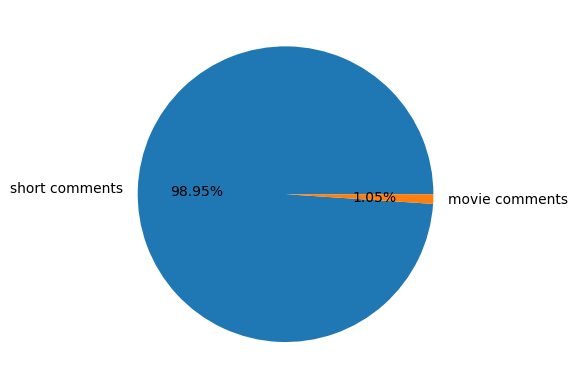

In [7]:
Labels='short comments','movie comments'
data=[shortComments,movieComments]
plt.pie(data,labels=Labels,autopct='%.2f%%')
plt.show()

## 第三题 爬取短评

In [8]:
#将网站下载到本地
url_1='https://movie.douban.com/subject/25662329/comments?limit=50&status=P&sort=new_score'
url_2='https://movie.douban.com/subject/25662329/comments?start={}&limit=50&status=P&sort=new_score'
url=[url_1,]
for i in range(50, 451, 50):
    url.append(url_2.format(i))

In [9]:
for i in range(len(url)):
    try:
        r=requests.get(url[i], headers=myHeaders)
        r.raise_for_status()
        r.encoding = 'utf-8'
        path='review_page{}.html'.format(i+1)
        
        with open(path,'w',encoding='utf-8') as file:
            file.write(r.text)
        
        time.sleep(3)
    
    except Exception as ex:
        print("第{}页采集出错，出错原因:{}".format(i+1,ex))

In [10]:
#处理评论内容（评分、发布时间、文本、以及有用数）
likes=[]
scores=[]
times=[]
comments=[]

all_users=[]
users={}
data={}

#人数计数器
count=0

for i in range(500):
    all_users.append('user{}'.format(i))
    users['user{}'.format(i)]=[]

In [11]:
for i in range(len(url)):
    with open(f'review_page{i+1}.html','r',encoding='utf-8') as file:
        html=file.read()
        soup=BeautifulSoup(html,'html.parser')

        div=soup.find('div',id='comments')

        for person in div.find_all('div',class_='comment-item'):
            information=person.find('div',class_='comment')

            span1=information.find('span',class_='votes vote-count')
            vote=span1.string
            users[f'user{count}'].append(vote)
            
            span2=information.find('span',class_='comment-info')
            score=re.compile("allstar(\d*)").findall(str(span2))
            if len(score)==0:
                users[f'user{count}'].append('NaN')
                scores.append(0)
            else:
                users[f'user{count}'].append(score[0])
                scores.append(int(score[0]))

            span3=information.find('span',class_='comment-time')
            time=re.compile('[0-99999]\d*').findall(span3.string)
            time_date=time[:3]
            date="".join(time_date)
            users[f'user{count}'].append(date)

            p=information.find('p',class_='comment-content')
            span4=p.find('span',class_='short')
            comment=span4.string
            users[f'user{count}'].append(comment)
            comments.append(comment)

            count=count+1
            
            likes.append(int(vote))
            times.append(int(date))

data['有用数']=likes
data['评分']=scores
data['发布时间']=times
data['文本']=comments

In [12]:
#存储为DataFrame
df=pd.DataFrame(data,index=all_users,columns=['有用数','评分','发布时间','文本'])

In [13]:
df

,有用数,评分,发布时间,文本
user0,11044,50,20160301,看过了这一部，我好像能够更坚定地说我会当迪士尼一辈子的粉丝。迪士尼给我们营造的乌托邦就是这样...
user1,8256,50,20160226,无论是人设，世界观，动画制作，还是剧本，都挑不出毛病来啊啊啊！！细节多到爆！！好幸福！！！！...
user2,6645,50,20160226,完爆冰雪超能头脑，动物再次证明了动画片不止是给小朋友看的，而是全年龄段和世界级的，尖端数码特...
user3,5502,50,20160223,做冰棍那机智的不像话！！！全片最爱！！！想吃！！！
user4,12088,40,20160302,树懒太他妈好笑了！！那两分钟我嗓子都哑了！！卧槽！！真是太他妈好笑了！！
...,...,...,...,...
user495,5,50,20160313,没有情怀没有生活阅历的人是做不出这部电影也不会喜欢的。虽然不至于是神作，但已突破王子公主灰姑娘。
user496,4,20,20160315,作为美帝潜伏份子，我真的，真的，被政治正确吓到了，也非常，非常的担心。
user497,7,40,20160402,挺好的，不过有点一看而过的感觉，只记得大家都很可爱了
user498,1,40,20171003,精彩的剧情、丰满的人设、老少皆宜的世界观、理想化的乌托邦，从配乐、色彩、叙事到整体都非常值得...


In [14]:
print(df[0:10])

         有用数  评分      发布时间                                                 文本
user0  11044  50  20160301  看过了这一部，我好像能够更坚定地说我会当迪士尼一辈子的粉丝。迪士尼给我们营造的乌托邦就是这样...
user1   8256  50  20160226  无论是人设，世界观，动画制作，还是剧本，都挑不出毛病来啊啊啊！！细节多到爆！！好幸福！！！！...
user2   6645  50  20160226  完爆冰雪超能头脑，动物再次证明了动画片不止是给小朋友看的，而是全年龄段和世界级的，尖端数码特...
user3   5502  50  20160223                          做冰棍那机智的不像话！！！全片最爱！！！想吃！！！
user4  12088  40  20160302               树懒太他妈好笑了！！那两分钟我嗓子都哑了！！卧槽！！真是太他妈好笑了！！
user5   2835  50  20160304              不要看任何影评，如果可以预告片都别看，直接买票就好了。你要啥这电影里有啥！
user6   2887  50  20160215  绝对的好片子 裂墙推荐。实在是因为另一场满了…随手挑了这个片子。真是5分钟一小笑 10分钟哄...
user7   5766  40  20160307  港真，面对人家动画片里连一把椅子扶手上的铝合金划痕都做得活灵活现的态度，咱们就默默低头学就好...
user8   2711  50  20160301                                       赞 看完赶脚世界都美好了
user9   2568  50  20160228  想嫁给又吊儿郎当又酷得不像话的狐狸先生。\n自认为是奥斯卡长篇动画的有力候选。\n啊啊啊，真...


## 展示词云 

In [15]:
with open('stop_word.txt','r',encoding='utf-8') as jiebafile:
    stop_words=jiebafile.readlines()
stop_words=[w.strip('\n') for w in stop_words]

In [16]:
text="".join(comments)
jiebaword=jieba.lcut(text)

for word in jiebaword:
    if len(word)==1:
        jiebaword.remove(word)

words= filter(lambda x: x not in stop_words,jiebaword)

all_words=','.join(words)
wcloud = wordcloud.WordCloud(font_path=r'毛笔体.ttf',width=1000, height=800,background_color='white',max_words=200,margin=2)
wcloud.generate(all_words)

wcloud.to_file('wordcloud.png')

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/0m/vq8y8p61471b1p9frgcwqgjh0000gn/T/jieba.cache
Loading model cost 0.634 seconds.
Prefix dict has been built successfully.


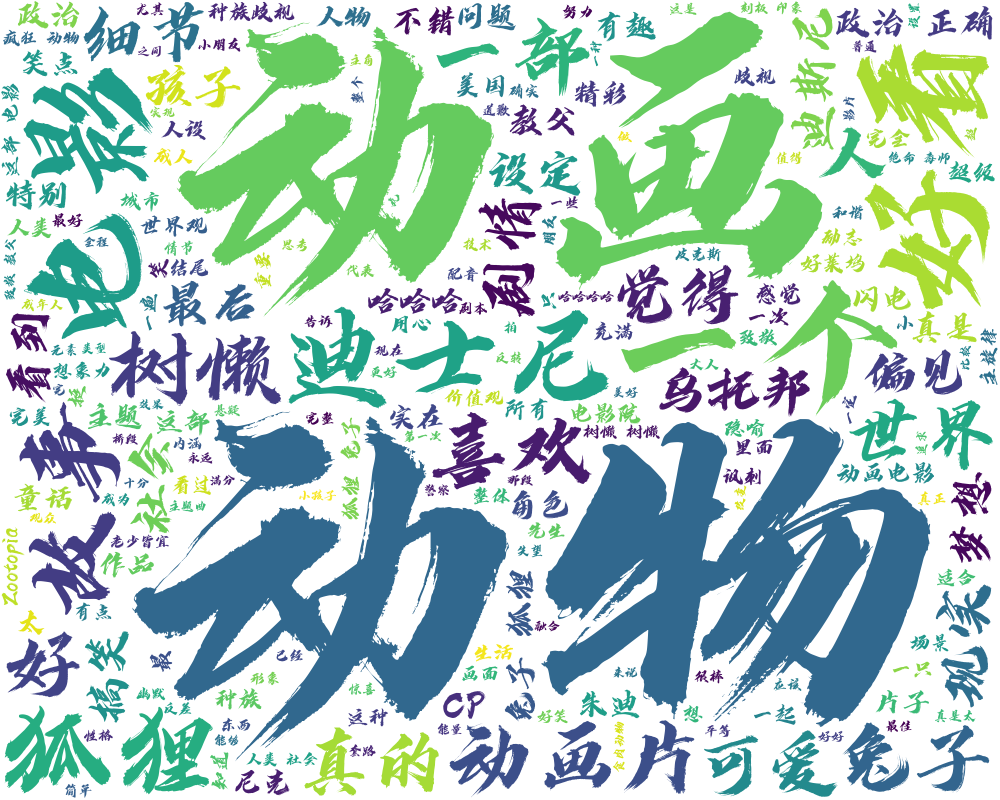

In [ ]:
Image('wordcloud.png')

## 第五题 好评、一般、差评分组画词云 

In [ ]:
def draw(comment):
    text="".join(comment)
    jiebaword=jieba.lcut(text)

    for word in jiebaword:
        if len(word)==1:
            jiebaword.remove(word)

    words= filter(lambda x: x not in stop_words,jiebaword)

    all_words=','.join(words)
    wcloud = wordcloud.WordCloud(font_path=r'毛笔体.ttf',width=1000, height=800,background_color='white',max_words=200,margin=2)
    wcloud.generate(all_words)
    
    return wcloud

In [19]:
good=[]
ok=[]
bad=[]

for j in range(500):
    if users[f'user{j}'][1]=='50' or users[f'user{j}'][2]=='40':
        good.append(users[f'user{j}'][3])
    elif users[f'user{j}'][2]=='30':
        ok.append(users[f'user{j}'][3])
    elif users[f'user{j}'][1]=='20' or users[f'user{j}'][2]=='10':
        bad.append(users[f'user{j}'][3])

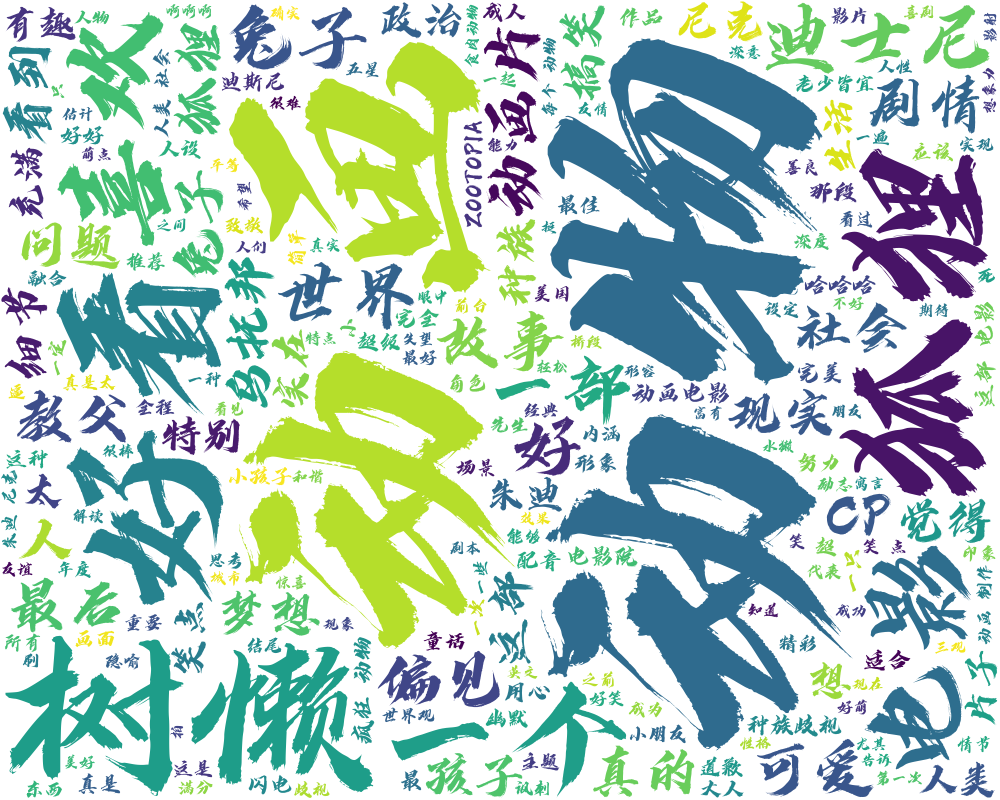

In [ ]:
good_wcloud=draw(good)
good_wcloud.to_file('wordcloud-好评.png')
Image('wordcloud-好评.png')

In [21]:
if len(ok)!=0:
    ok_wcloud=draw(ok)
    ok_wcloud.to_file('wordcloud-一般.png')
else:
    print("该电影没有一般评论！")

该电影没有一般评论！


In [22]:
if len(bad)!=0:
    bad_wcloud=draw(bad)
    bad_wcloud.to_file('wordcloud-差评.png')
else:
    print("该电影没有差评评论！")

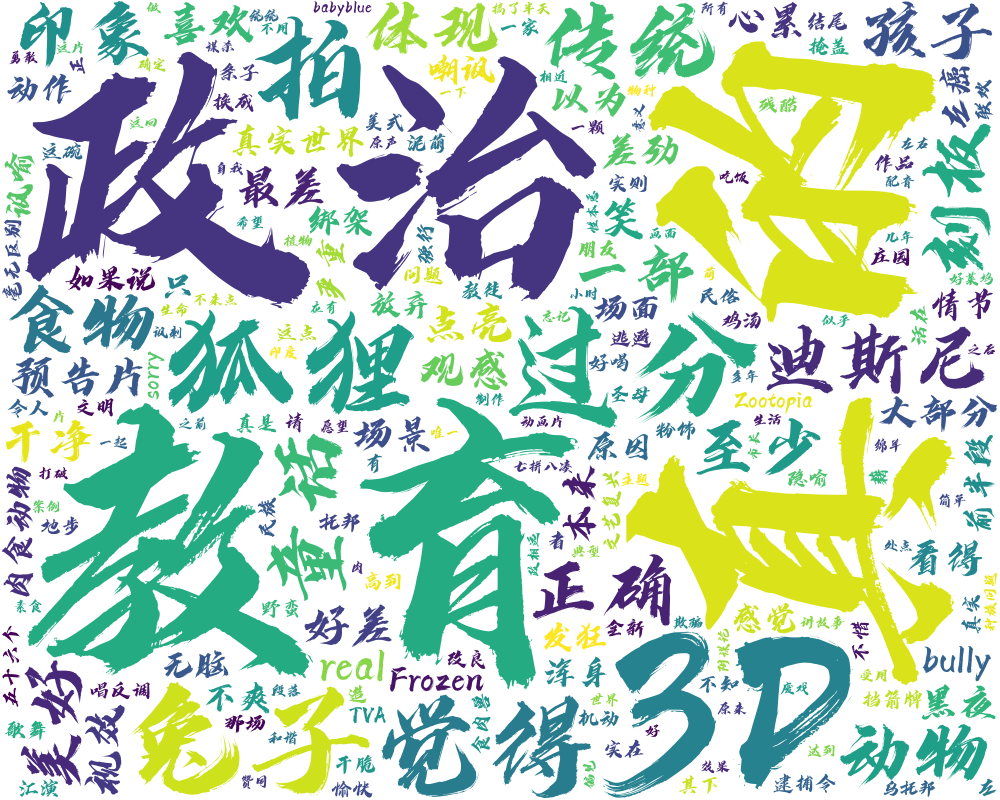

In [ ]:
Image('wordcloud-差评.png')

## 第六题 按时间排序

In [ ]:
df=df.sort_values(by=['发布时间'],ascending=False)
df

,有用数,评分,发布时间,文本
user290,19,50,20230814,当年的皮克斯动画是真好看，在没有太多政治正确的情况下能把社会歧视问题讲得清清楚楚
user203,23,50,20220623,“我知道你爱我”\n哎呀呀，狐兔cp也太甜了吧……\n同时也是在反对种族歧视……
user266,32,50,20220218,这个作品最神仙的地方就是，你浅看就是一个姣好且充满创意的冒险片。你深看就是一个“人类寓言”，...
user252,40,50,20220125,五年后再看疯狂动物城，这是一个身份撕裂的社会中一个人做美国梦的故事，最后以童话式的皆大欢喜实...
user442,11,50,20210818,你是什么样子不重要，重要的是你想成为什么样子。
...,...,...,...,...
user2,6645,50,20160226,完爆冰雪超能头脑，动物再次证明了动画片不止是给小朋友看的，而是全年龄段和世界级的，尖端数码特...
user28,1132,40,20160224,故事中规中矩，立意却是小孩看了笑大人看了深思的寓言故事。It's a story about...
user3,5502,50,20160223,做冰棍那机智的不像话！！！全片最爱！！！想吃！！！
user76,184,50,20160221,全程笑裂！超慢速水獭素预告片就已经笑死，还有🐑睡觉也要数绵羊的梗啊哈哈哈哈！\n既能教育小朋...


In [25]:
df_score=df.drop('文本', axis=1)
timegroup = df_score.groupby('发布时间')
print(list(timegroup))

avg=df_score.groupby("发布时间").agg('mean')
print(avg)

[(20160215,         有用数  评分      发布时间
user6  2887  50  20160215), (20160221,         有用数  评分      发布时间
user76  184  50  20160221), (20160223,         有用数  评分      发布时间
user3  5502  50  20160223), (20160224,          有用数  评分      发布时间
user28  1132  40  20160224), (20160226,         有用数  评分      发布时间
user1  8256  50  20160226
user2  6645  50  20160226), (20160227,          有用数  评分      发布时间
user29   375  50  20160227
user46   305  50  20160227
user302  130  50  20160227), (20160228,          有用数  评分      发布时间
user13   949  50  20160228
user9   2568  50  20160228), (20160301,            有用数  评分      发布时间
user8     2711  50  20160301
user259    258  50  20160301
user36     127  50  20160301
user34     587  40  20160301
user0    11044  50  20160301), (20160302,           有用数  评分      发布时间
user4   12088  40  20160302
user42    110  50  20160302
user16   4045  40  20160302), (20160303,          有用数  评分      发布时间
user48    81  50  20160303
user40   112  50  20160303
user270   13  40  20160303)

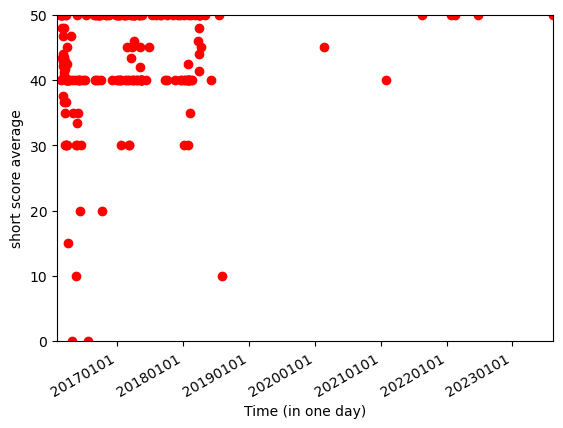

In [31]:
import matplotlib.dates as mdates
# 假设 times 是日期列表，avg['评分'] 包含对应的评分
setTimes = set(times)
listTimes = list(setTimes)
listTimes.sort(reverse=False)

# 将日期从整数转换为 datetime 对象
x = [pd.to_datetime(str(date), format='%Y%m%d') for date in listTimes]
y = list(avg['评分'])

plt.scatter(x, y, color='r')

# 设置日期格式
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y%m%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

# 自动旋转日期标记以适应显示
plt.gcf().autofmt_xdate()

# 设置x轴和y轴的范围
plt.xlim(pd.to_datetime('20160201', format='%Y%m%d'), pd.to_datetime('20230814', format='%Y%m%d'))
plt.ylim(0, 50)

plt.xlabel('Time (in one day)')
plt.ylabel('short score average')

plt.show()

In [27]:
def weigh_avg(group,a,b):
    temp1=group[a]
    temp2=group[b]
    return ((temp1*temp2).sum())/temp2.sum()

In [28]:
weighavg=timegroup.apply(weigh_avg,'评分','有用数')

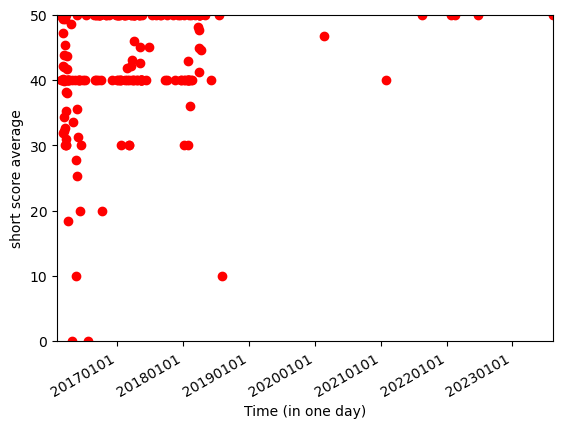

In [32]:
# 将日期从整数转换为 datetime 对象
x = [pd.to_datetime(str(date), format='%Y%m%d') for date in listTimes]
y = list(weighavg)

plt.scatter(x, y, color='r')

# 设置日期格式
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y%m%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

# 自动旋转日期标记以适应显示
plt.gcf().autofmt_xdate()

# 设置x轴和y轴的范围
plt.xlim(pd.to_datetime('20160201', format='%Y%m%d'), pd.to_datetime('20230814', format='%Y%m%d'))
plt.ylim(0, 50)

plt.xlabel('Time (in one day)')
plt.ylabel('short score average')

plt.show()

# 第七题 情感分数

In [33]:
from snownlp import SnowNLP

# 假设您已经有一个包含评论的DataFrame
# df['评论'] 是存储评论文本的列
df['情感分数'] = df['文本'].apply(lambda x: SnowNLP(x).sentiments)

# 情感分数接近1表示正面情绪，接近0表示负面情绪
df.head()

,有用数,评分,发布时间,文本,情感分数
user290,19,50,20230814,当年的皮克斯动画是真好看，在没有太多政治正确的情况下能把社会歧视问题讲得清清楚楚,0.968909
user203,23,50,20220623,“我知道你爱我”\n哎呀呀，狐兔cp也太甜了吧……\n同时也是在反对种族歧视……,0.999463
user266,32,50,20220218,这个作品最神仙的地方就是，你浅看就是一个姣好且充满创意的冒险片。你深看就是一个“人类寓言”，...,1.000000
user252,40,50,20220125,五年后再看疯狂动物城，这是一个身份撕裂的社会中一个人做美国梦的故事，最后以童话式的皆大欢喜实...,1.000000
user442,11,50,20210818,你是什么样子不重要，重要的是你想成为什么样子。,0.629860


In [ ]:
df_score=df.drop('文本', axis=1)
timegroup = df_score.groupby('发布时间')
avg=df_score.groupby("发布时间").agg('mean')
weighavg=timegroup.apply(weigh_avg,'情感分数','有用数')

# 将日期从整数转换为 datetime 对象
x = [pd.to_datetime(str(date), format='%Y%m%d') for date in listTimes]
y = list(weighavg)

plt.scatter(x, y, color='r')

# 设置日期格式
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y%m%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

# 自动旋转日期标记以适应显示
plt.gcf().autofmt_xdate()

# 设置x轴和y轴的范围
plt.xlim(pd.to_datetime('20160201', format='%Y%m%d'), pd.to_datetime('20230814', format='%Y%m%d'))
plt.ylim(0, 1)

plt.xlabel('Time (in one day)')
plt.ylabel('Emotion score average')

plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 为LDA准备文本数据
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')# max_df 参数用于过滤掉过于频繁出现的词汇；min_df 参数用于过滤掉过于稀有的词汇
dtm = vectorizer.fit_transform(df['文本'])

# 使用LDA模型
lda = LatentDirichletAllocation(n_components=10)  # n_components是主题的数量
lda.fit(dtm)

# 显示每个主题的前若干关键词
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

print_top_words(lda, vectorizer.get_feature_names_out(), 10)


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import jieba

# 假设 df 是包含评论数据的DataFrame，有一个名为 '评论' 的列
comments = df['文本'].tolist()

# 中文分词
def chinese_tokenizer(text):
    return jieba.lcut(text)

# 使用TF-IDF进行向量化
vectorizer = TfidfVectorizer(tokenizer=chinese_tokenizer, stop_words='english')
X = vectorizer.fit_transform(comments)

# 应用K-means聚类
n_clusters = 5  # 假设我们想要形成5个簇
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

# 将聚类结果添加到原始数据框中
df['Cluster'] = kmeans.labels_

# 查看每个簇的评论
for i in range(n_clusters):
    cluster_comments = df[df['Cluster'] == i]['文本']
    print(f"Cluster {i}:")
    print(cluster_comments.head())  # 打印每个簇的前几条评论
    print("\n")
